# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy.stats import pearsonr, spearmanr

from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import calibration_curve

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import time

# NBA ROOKIE

# Contexto e hipotesis

El objetivo a cumplir con este dataset consiste en precedir ['TARGET_5Yrs'] si un jugador novato/debutante tendra una carrera de mas de 5 años en la NBA.

¿Se distribuyen en forma equitativa los jugadores segun la variable de respuesta?

¿Cuales son aquellas variables que menor correlacion tienen con la duracion de la carrera?

Las variables "ofensivas" (que generan situacion de ataque y/o puntos) ¿guardan mayor relacion que las "defensivas" sobre la duracion de la carrera?

# Análisis exploratorio de datos

In [2]:
df = pd.read_csv("NBA_rookie_stats.csv")

Descripcion campos
<img src= "descripcion_variables_nba_rookie.jpeg"/>

In [3]:
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

Como podemos ver, contamos con las principales estadisticas del basket (o las mas basicas...) para cada uno de los jugadores incluidos.

Tambien observamos que no contamos con datos nulos. No se observan discrepancias entre los formatos y contenido (valores) de cada variable, vemos una base con columnas numericas (float64 en su gran mayoria). Por lo que no resulta necesario, al momento, realizar correcciones o imputaciones sobre los datos.

## Conociendo los datos

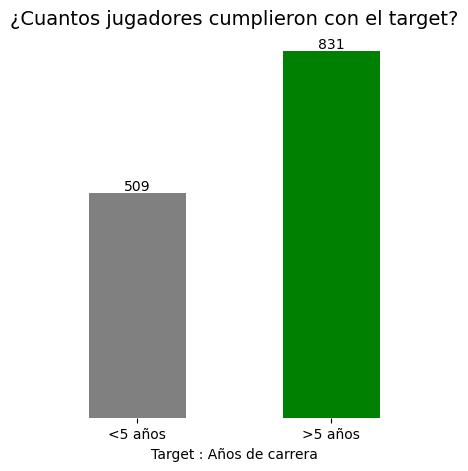

In [5]:
players_vs_target = df.groupby (["TARGET_5Yrs"]).count()["Name"]

fig, ax = plt.subplots(1,1, figsize=(5,5))

players_vs_target.plot.bar(color=['grey', 'green'])
ax.set_xlabel("Target : Años de carrera")
ax.set_title("¿Cuantos jugadores cumplieron con el target?", fontsize = 14)
ax.set_xticklabels(["<5 años", ">5 años"], rotation=0)
ax.set_yticklabels([])
ax.set_yticks([])  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False)

for a, b in enumerate(players_vs_target):
    ax.text(a, b, str(b), ha='center', va='bottom')

Mi variable de respuesta, se encuentra desbalanceada respecto al tamaño total de la base. Ya que el 62% de los jugadores alcanzo una carrera mayor a 5 años, mientras que 38% restante tuvo una carrera menor a 5 años

¿Cual es el promedio de partidos jugados, minutos, puntos y goles hechos?

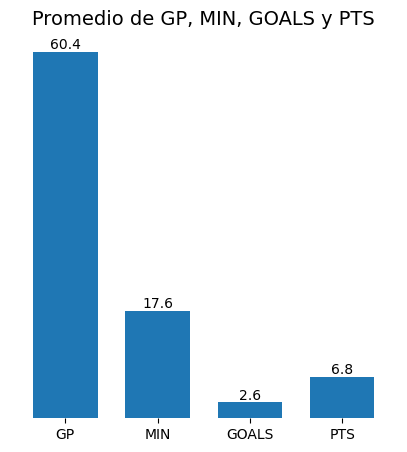

In [6]:
promedios = round(df[['GP', 'MIN', 'FGM','PTS']].mean(),1)
fig, ax = plt.subplots(1,1, figsize=(5,5))
promedios.plot(kind='bar',
               ax=ax,
               width=0.7)
ax.set_title('Promedio de GP, MIN, GOALS y PTS', fontsize = 14)
ax.set_xticklabels(['GP', 'MIN', 'GOALS','PTS'],rotation=0)
ax.set_yticklabels([])
ax.set_yticks([])  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False)


for c, d in enumerate(promedios):
    ax.text(c, d, str(d), ha='center', va='bottom')

¿Cuantos son los jugadores que se encuentran por encima del promedio en cada una de estas variables?

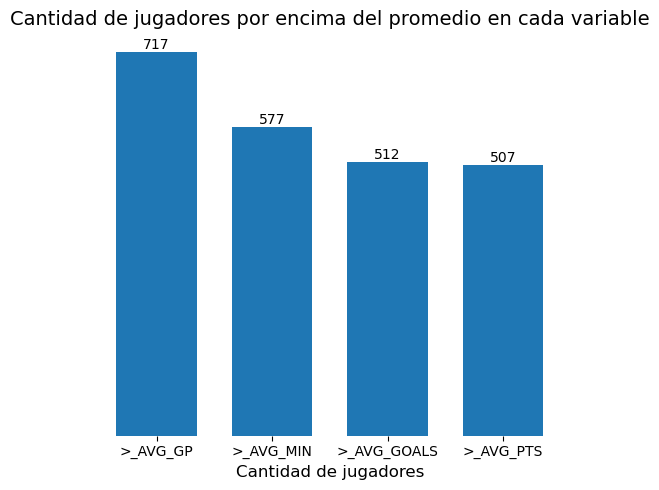

In [7]:
promedio_GP = df['GP'].mean()
promedio_MIN = df['MIN'].mean()
promedio_GOALS = df['FGM'].mean()
promedio_PTS = df['PTS'].mean()

jugadores_masavg_GP = len(df[df['GP'] > promedio_GP])
jugadores_masavg_MIN = len(df[df['MIN'] > promedio_MIN])
jugadores_masavg_GOALS = len(df[df['FGM'] > promedio_GOALS])
jugadores_masavg_PTS = len(df[df['PTS'] > promedio_PTS])

variables = ['>_AVG_GP', '>_AVG_MIN', '>_AVG_GOALS','>_AVG_PTS']
jugadores = [jugadores_masavg_GP, jugadores_masavg_MIN, jugadores_masavg_GOALS,jugadores_masavg_PTS]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.bar(variables, jugadores, width=0.7) 
plt.xlabel('Cantidad de jugadores', fontsize=12)
plt.title('Cantidad de jugadores por encima del promedio en cada variable', fontsize=14)
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

for e, f in enumerate(jugadores):
    ax.text(e, f, str(f), ha='center', va='bottom')

plt.tight_layout()

Con el objetivo de comprender el impacto individual de cara variable, sobre mi variable de respuesta, opto por realizar correlaciones.

¿Cuales son aquellas variables que menor correlacion tienen con la duracion de la carrera?

Text(0.5, 1.0, 'Correlaciones con TARGET_5Yrs')

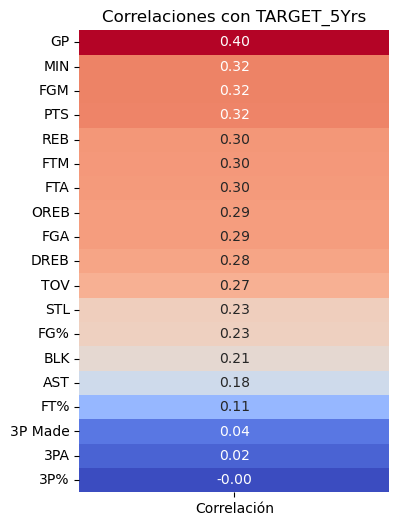

In [8]:
cols_num = df.select_dtypes(include=['float64', 'int64']).drop(columns=['TARGET_5Yrs']).columns

correlaciones = df[cols_num].corrwith(df['TARGET_5Yrs'])

correlaciones_df = pd.DataFrame(correlaciones, columns=['Correlación'])

correlation_matrix = correlaciones_df.sort_values(by='Correlación', ascending=False)#df[cols_num + ['TARGET_5Yrs']].corr()

# MAPA DE CALOR
plt.figure(figsize=(4, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            cbar=False,
            cbar_kws={"use_gridspec": False}
           )
plt.title('Correlaciones con TARGET_5Yrs')

Opto por comenzar el preparado de la base, eliminando aquellas variables que menor correlacion tienen. De forma tal que me permita avanzar con mayor facilidad la exploracion de datos

In [9]:
df = df.drop(columns=["FT%"
                   ,"3P Made"
                   ,"3PA"
                   ,"3P%"
                  ])

In [10]:
cols_num = df.select_dtypes(include=['float64', 'int64']).drop(columns=['TARGET_5Yrs']).columns

<AxesSubplot:>

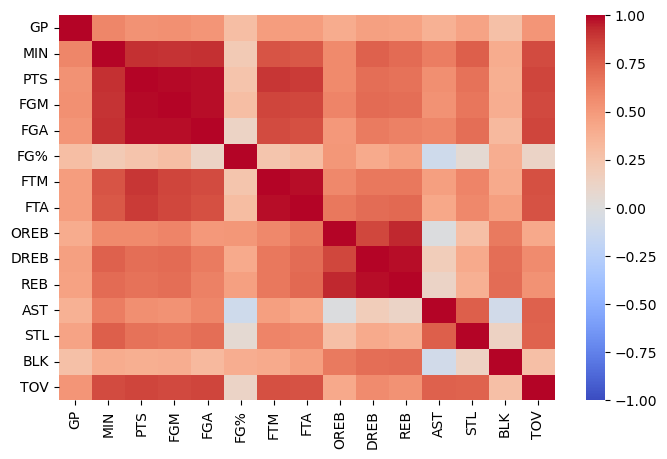

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

sns.heatmap(df[cols_num].corr()
            , cmap="coolwarm"
            ,vmin=-1
           )

Continuo con el preparado de la base... optare por quedarme unicamente con aquellas variables que:
    - Tienen mayor correlacion vs la variable de respuesta 'TARGET_5Yrs'
    - Que a su vez tengan mayor relacion "entre si"

In [12]:
df = df.drop(columns=["FG%"
                   ,"BLK"
                  ])

Las variables "ofensivas" (que generan situacion de ataque y/o puntos) ¿guardan mayor relacion que las "defensivas" sobre la duracion de la carrera?

In [13]:
cols_num = df.select_dtypes(include=['float64', 'int64']).drop(columns=['TARGET_5Yrs']).columns

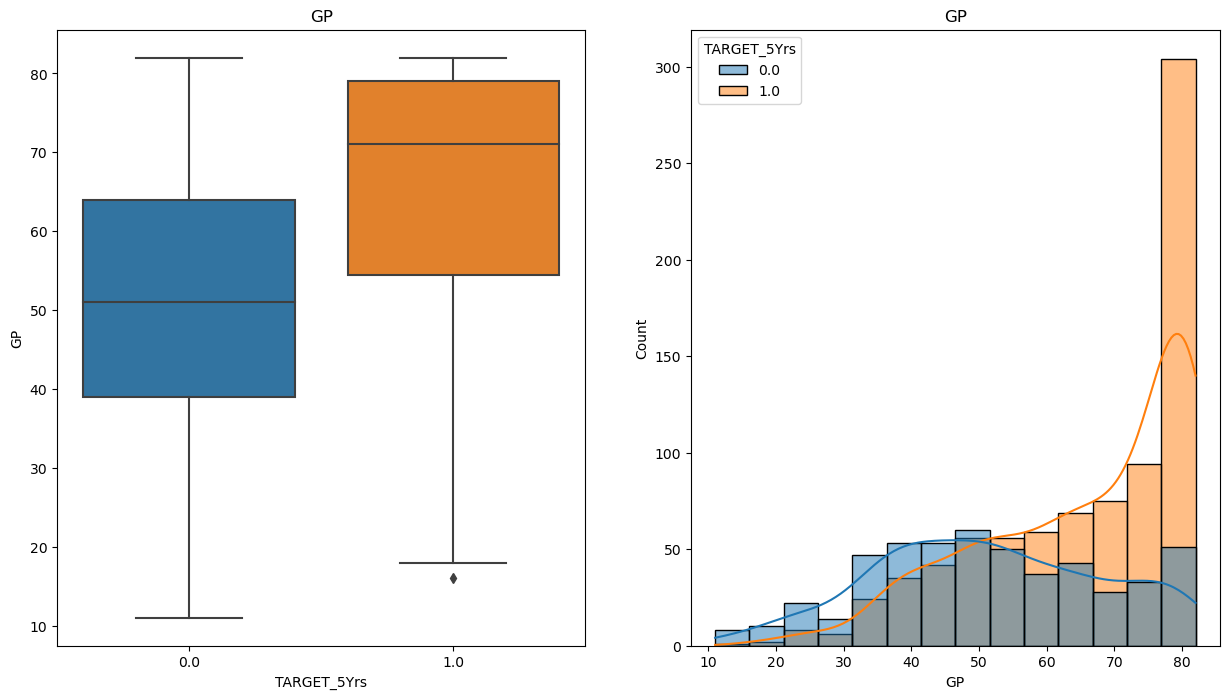

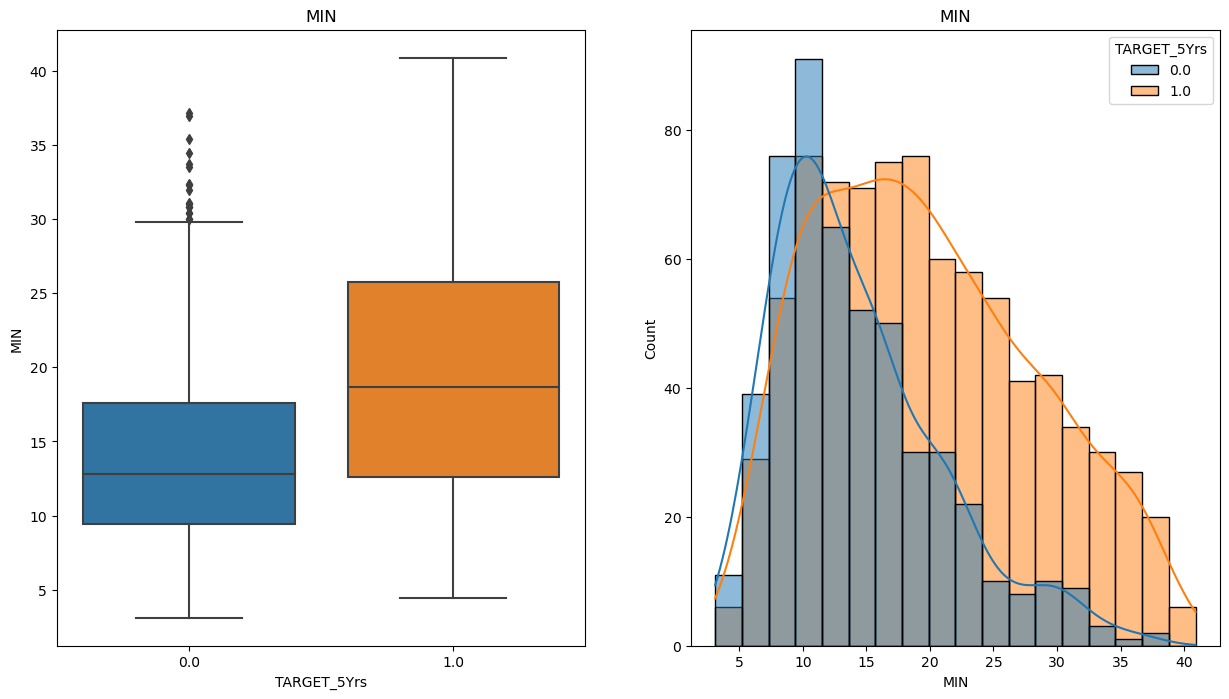

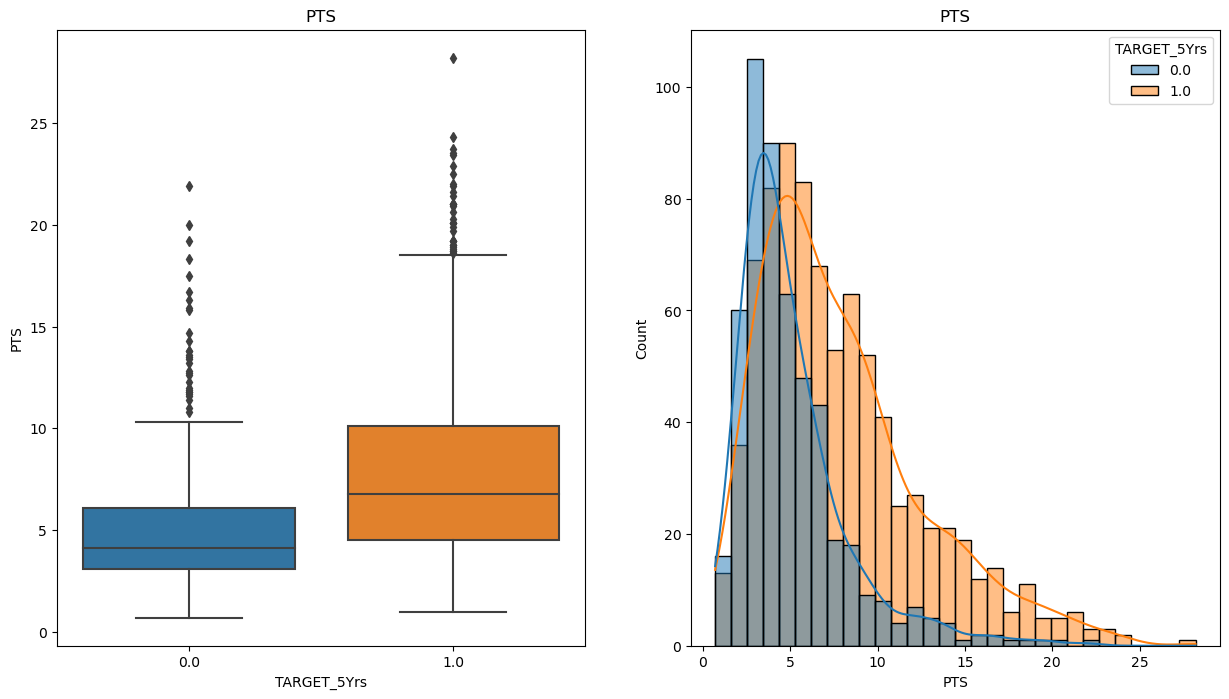

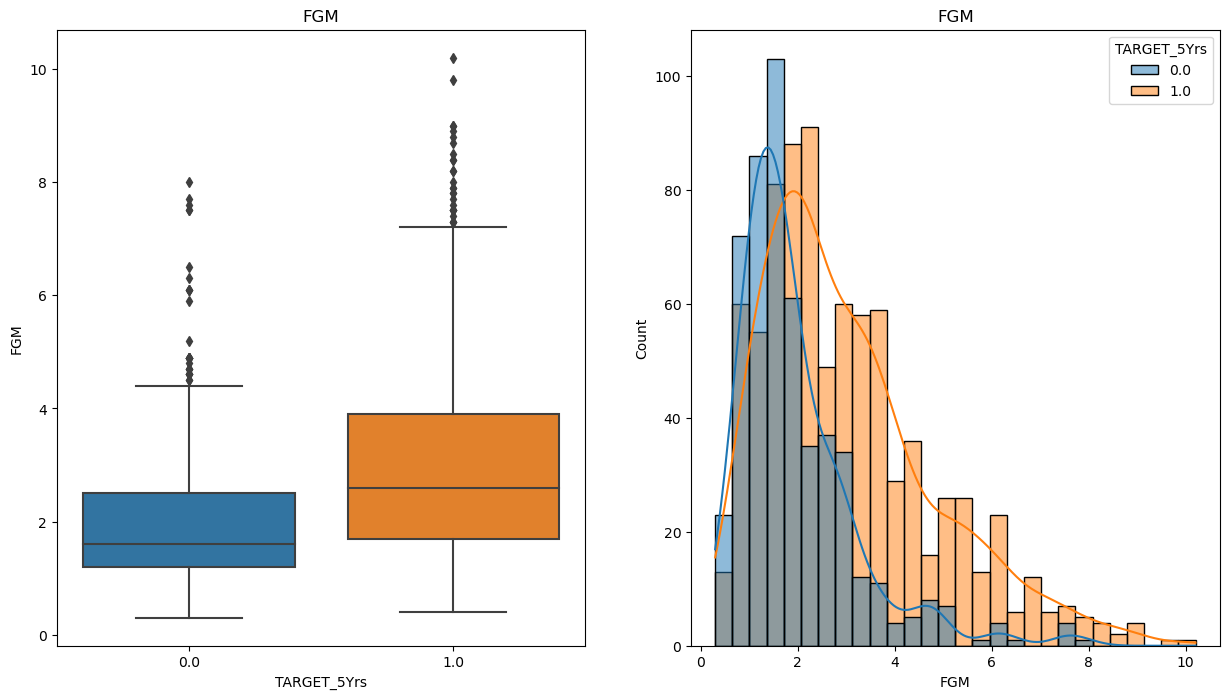

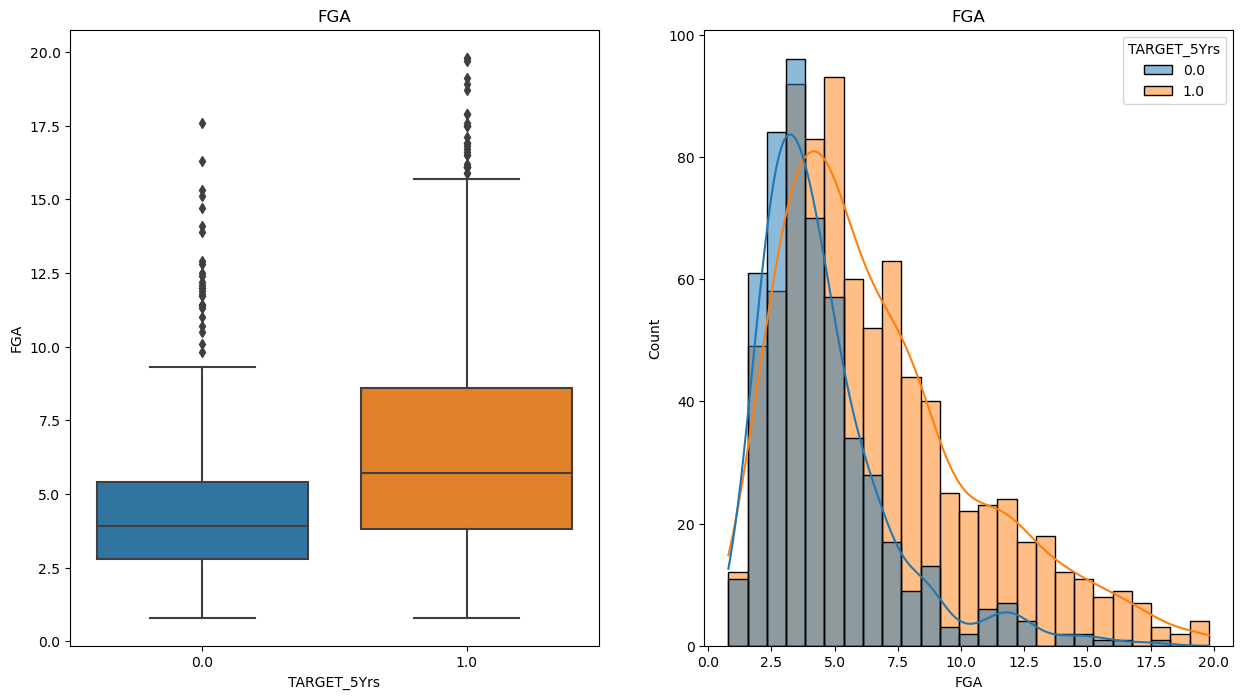

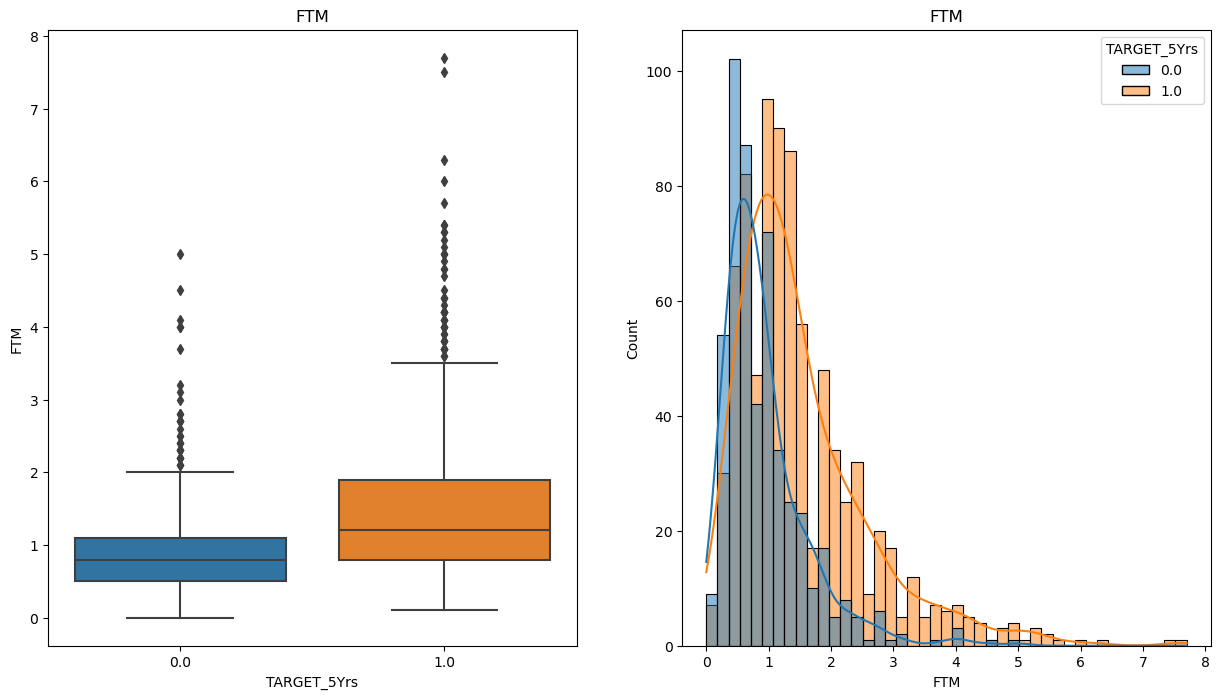

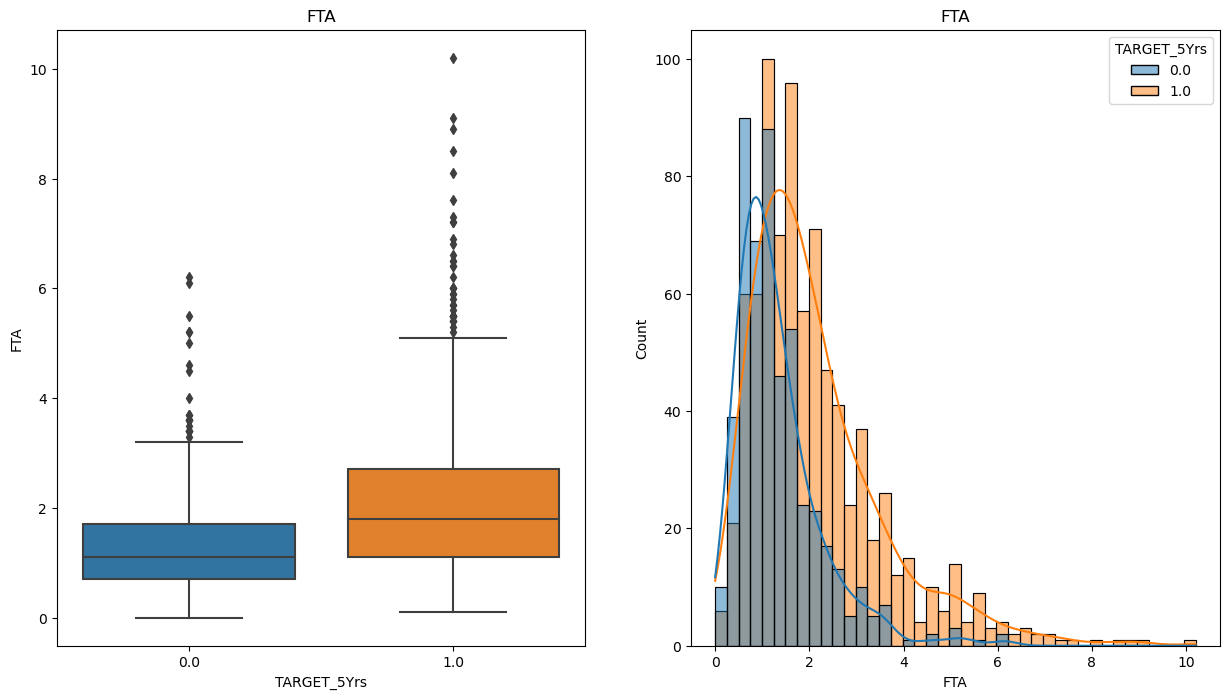

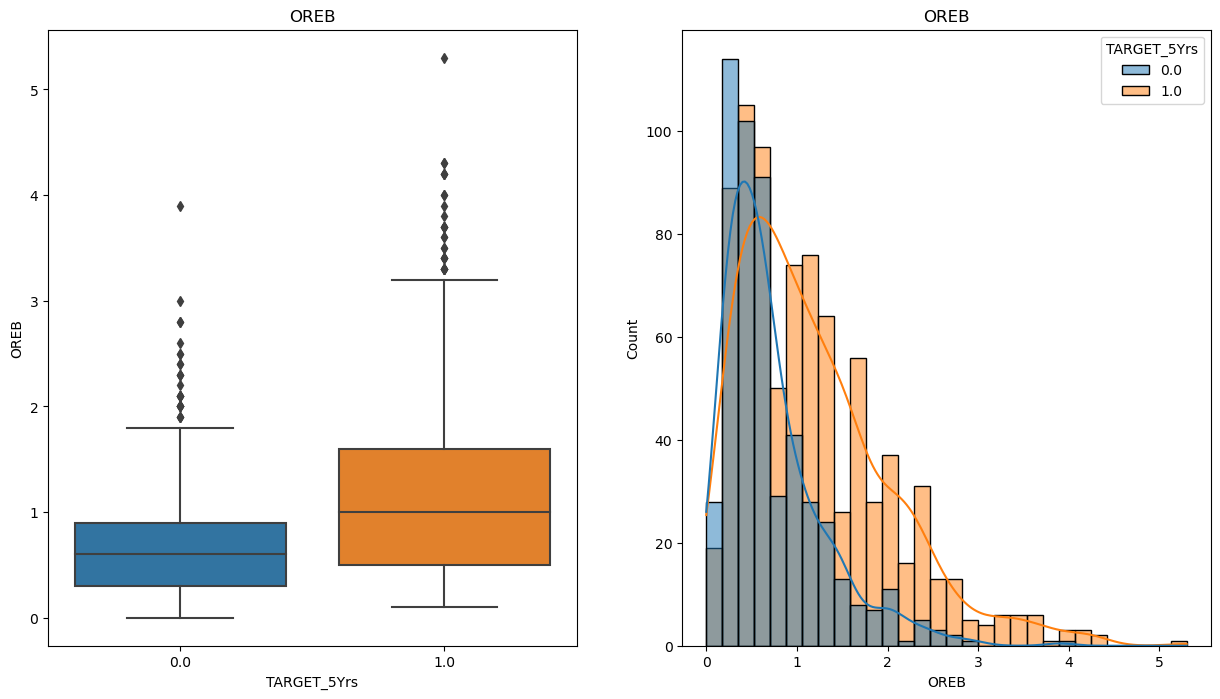

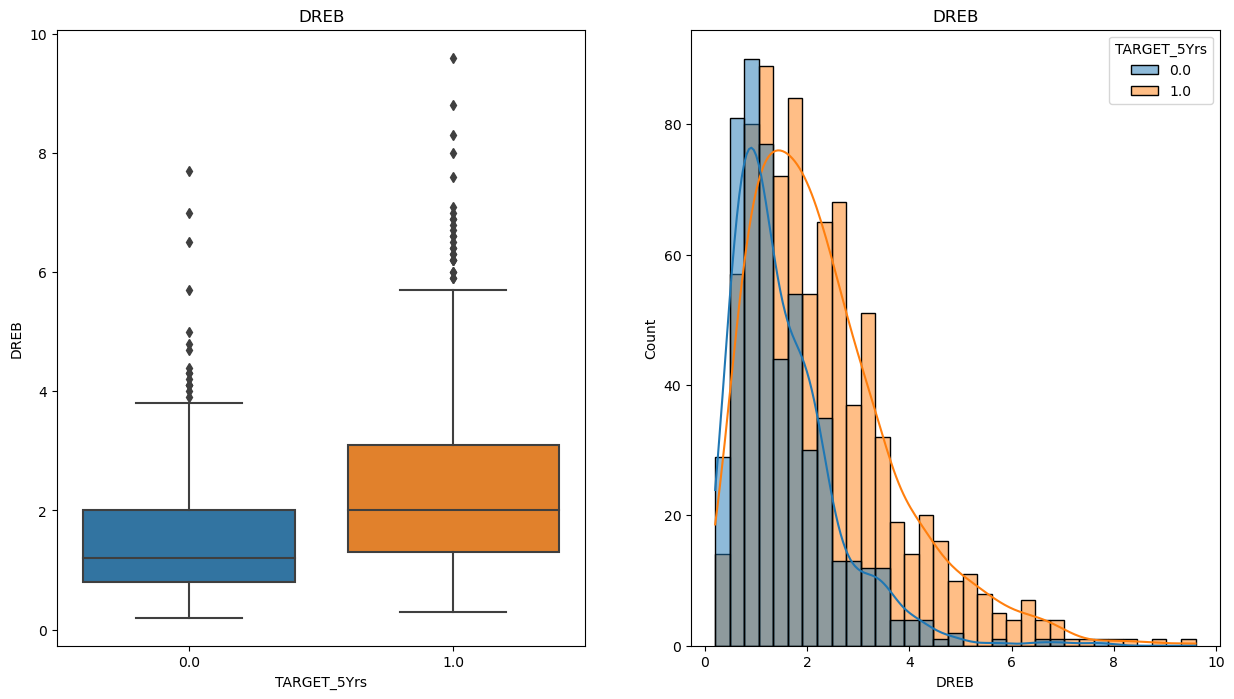

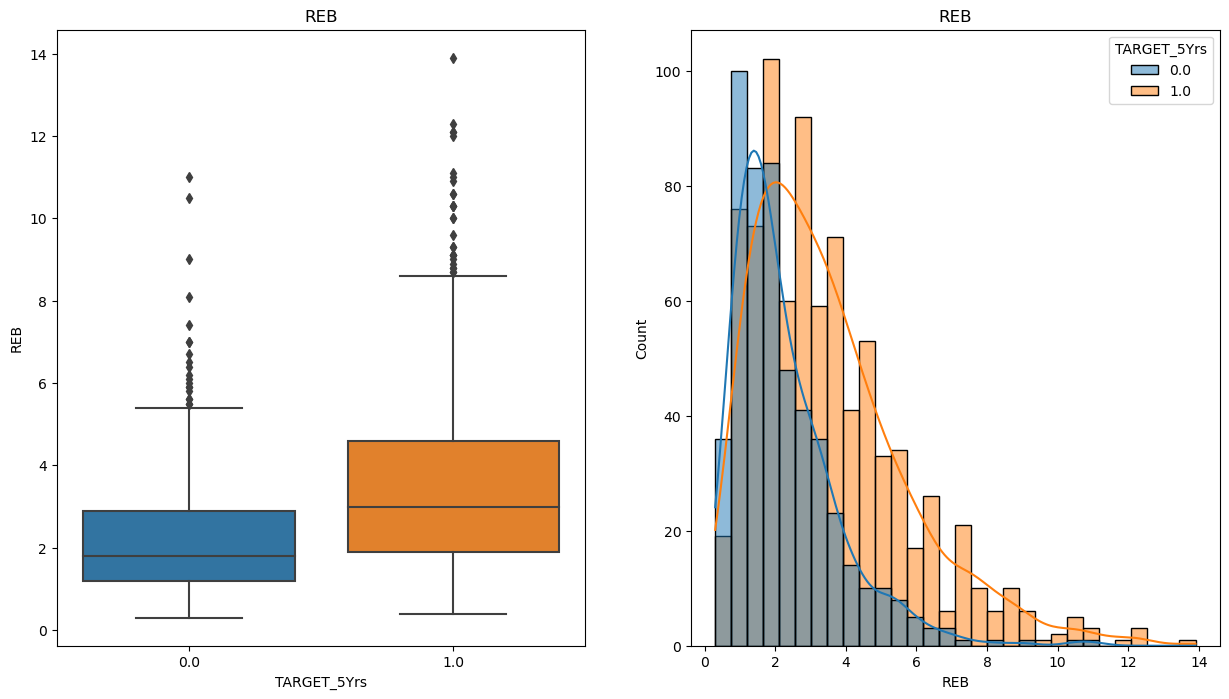

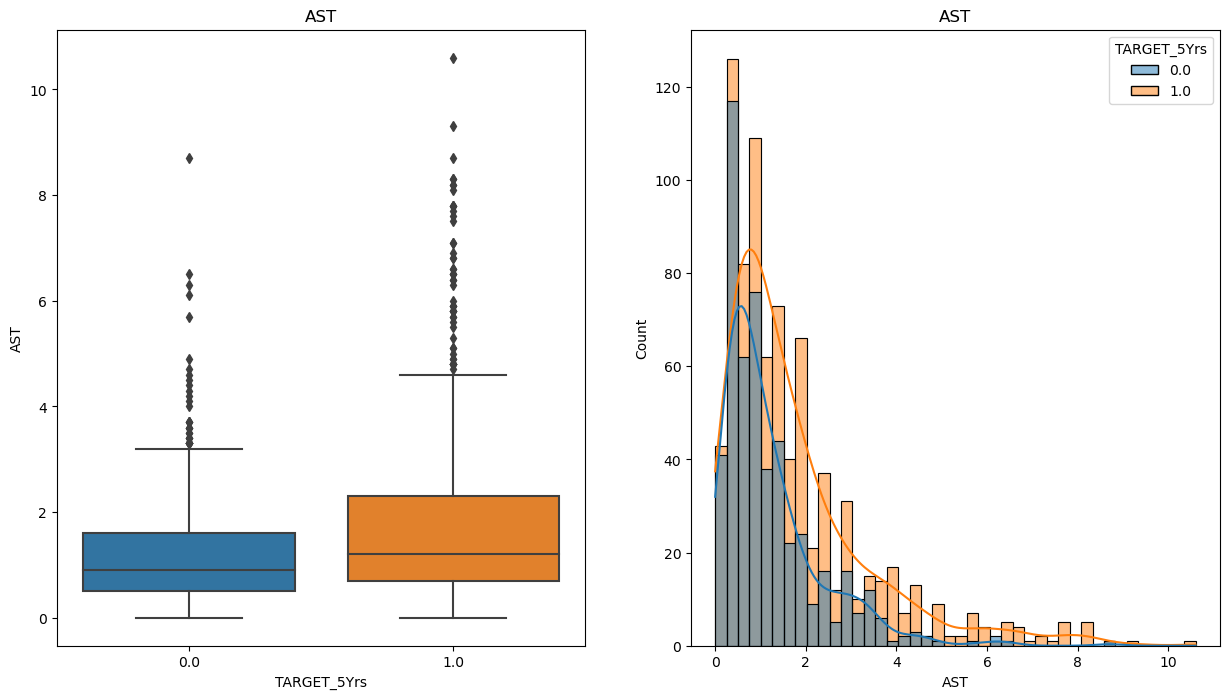

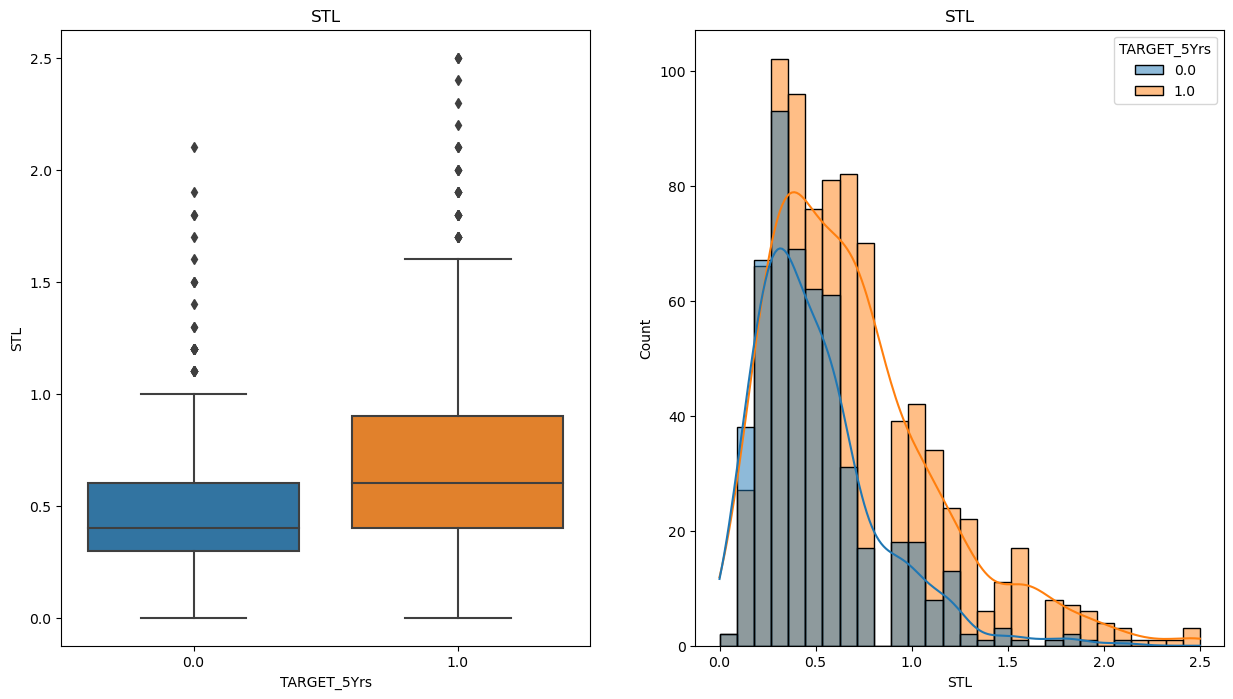

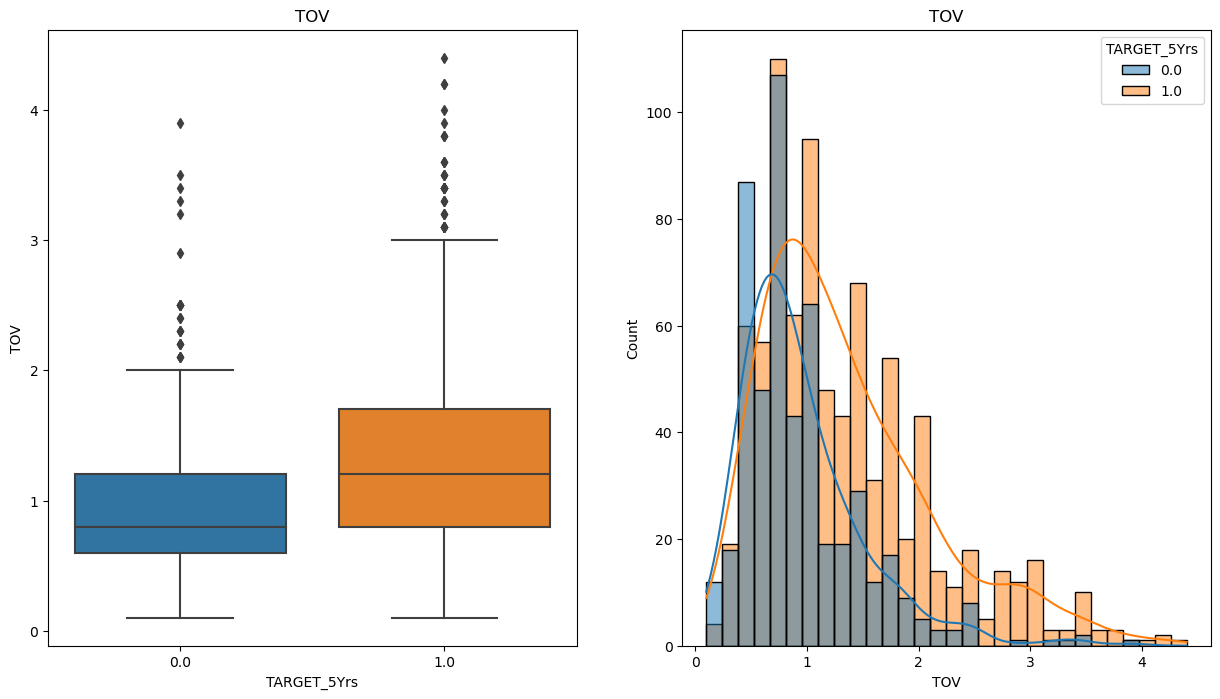

In [14]:
for col in cols_num:

    fig, ax = plt.subplots(1,2, figsize=(15,8))

    sns.boxplot(data=df,
                ax=ax[0],
                y=df[col],
                x="TARGET_5Yrs" 
               )
    ax[0].set_title(col)
    
    sns.histplot(data = df,
                 ax=ax[1],
                 x=df[col],
                 hue='TARGET_5Yrs',
                 kde=True
                ) 
    ax[1].set_title(col)

Como evidencian los graficos, podemos entender mejor porque estas 4 variables son las que mejor correlacionan vs el target. En todos los casos, aquellos jugadores que cumplieron el objetivo tienden a tener mejores "valores" para cada variable vs aquellos que no cumplieron el objetivo.

Comparaciòn correlacion Pearson vs Spearman

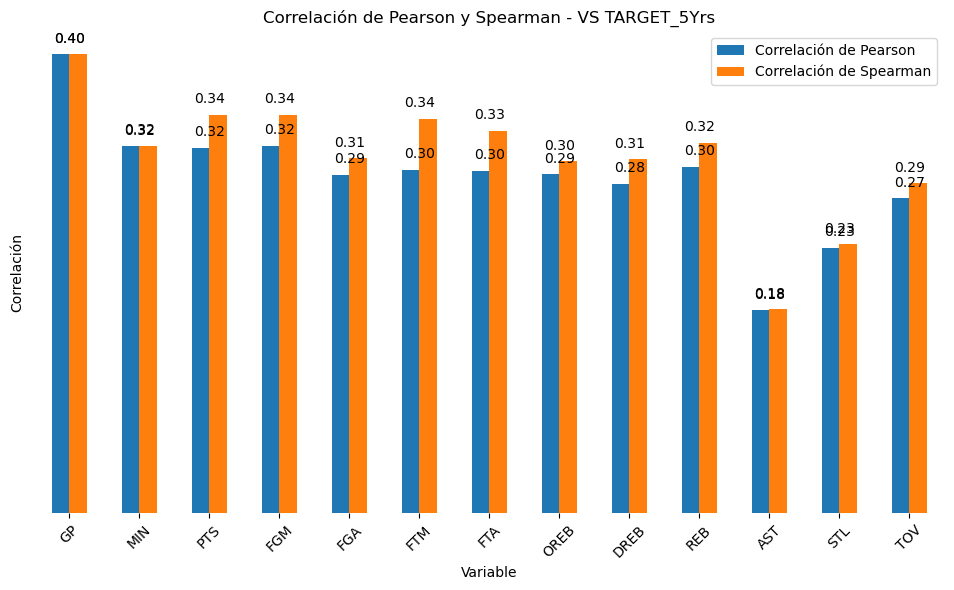

In [15]:
variables_independientes = ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'TOV']

variable_respuesta = 'TARGET_5Yrs'

# Listas para las correlaciones
corr_pearson_list = []
corr_spearman_list = []

# La correlación para cada variable
for var in variables_independientes:
    corr_pearson, _ = pearsonr(df[var], df[variable_respuesta])
    corr_spearman, _ = spearmanr(df[var], df[variable_respuesta])
    corr_pearson_list.append(corr_pearson)
    corr_spearman_list.append(corr_spearman)

# Crear un dataframe con los resultados
correlation_df = pd.DataFrame({'Variable': variables_independientes,
                               'Correlación de Pearson': corr_pearson_list,
                               'Correlación de Spearman': corr_spearman_list})

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))
correlation_df.plot(x='Variable', y=['Correlación de Pearson', 'Correlación de Spearman'], kind='bar', ax=ax)
ax.set_ylabel('Correlación')
ax.set_title('Correlación de Pearson y Spearman - VS TARGET_5Yrs')
plt.xticks(rotation=45)
plt.tight_layout()
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
# Etiquetas
for i, corr_pearson, corr_spearman in zip(range(len(variables_independientes)), corr_pearson_list, corr_spearman_list):
    ax.text(i, corr_pearson + 0.01, f'{corr_pearson:.2f}', ha='center')
    ax.text(i, corr_spearman + 0.01, f'{corr_spearman:.2f}', ha='center')

Como podemos observar en la grafica, en muchas de las variables la correlacion de Spearman, es mejor que Pearson. Esto tiene total sentido por el comportamiento de los datos en dichas variables. Como habiamos visto anteriormente, muchas de estas tienen un porcentaje de los datos como outliers

# Modelos ML

In [16]:
X = df.drop(columns=['TARGET_5Yrs','Name'])
y = df['TARGET_5Yrs']

# Guardo resultados

In [17]:
# Creo DF para ir guardando los resultados
column_names = ["Metodo",
        "Accuracy",
        "Precision",
        "Recall",
        "ROCAUC",
        "F1-Score",
        "FPR",
        "FNR",
        "Tiempo"]

resultados_df = pd.DataFrame(columns = column_names)

# Guardo los resultados
def guardo_resultados(metodo, y_test, y_pred, tiempo_ejecucion):
    #from sklearn import metrics
    resultados = {}
    resultados['Metodo'] = metodo
    resultados['Accuracy'] = metrics.accuracy_score(y_test, y_pred)
    resultados['Recall'] = metrics.recall_score(y_test, y_pred)
    resultados['Precision'] = metrics.precision_score(y_test, y_pred, zero_division=1)
    resultados['ROCAUC'] = metrics.roc_auc_score(y_test, y_pred)
    resultados['F1-Score'] = metrics.f1_score(y_test, y_pred)

    # Calcula el número de falsos positivos (FP), verdaderos negativos (TN), falsos negativos (FN) y verdaderos positivos (TP)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

    # Calcula las métricas FPR y FNR
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    resultados['FPR'] = fpr
    resultados['FNR'] = fnr

    resultados['Tiempo'] = tiempo_ejecucion

    return resultados

## Matriz de confusion

In [18]:
def plot_confusion_matrix(y_true, y_pred, modelo, normalize=False, cmap=plt.cm.Blues, ax=None):
    title = f"{modelo}"
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = np.unique(np.concatenate((y_true, y_pred), axis=0))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

## Evaluacion de modelos

In [19]:
modelo_logreg = LogisticRegression()
modelo_rf = RandomForestClassifier()
modelo_svc = SVC(probability=True)
modelo_xgb = XGBClassifier()
modelo_adaboost = AdaBoostClassifier()
modelo_knn = KNeighborsClassifier()

Regresion Logistica

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\3426231386.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


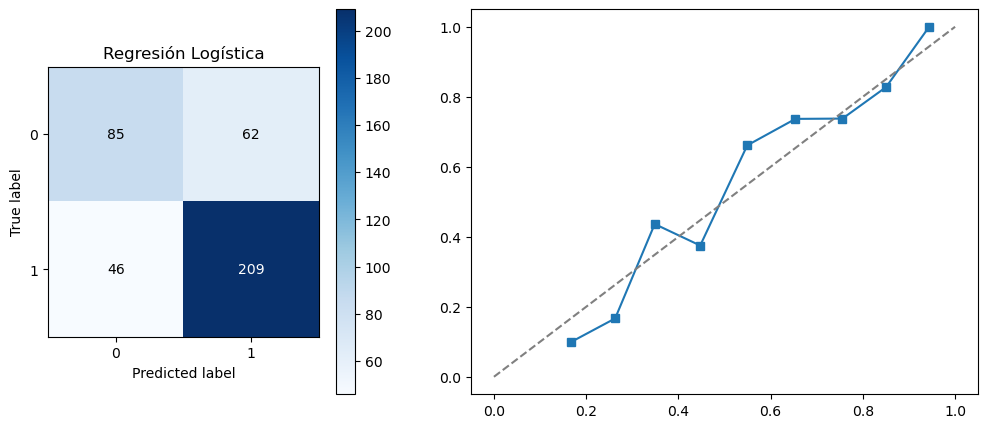

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_logreg = modelo_logreg.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_logreg.predict(X_test)

resultados = guardo_resultados('Regresión Logística', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'Regresión Logística'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_logreg.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

Random Forest

C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\595750218.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


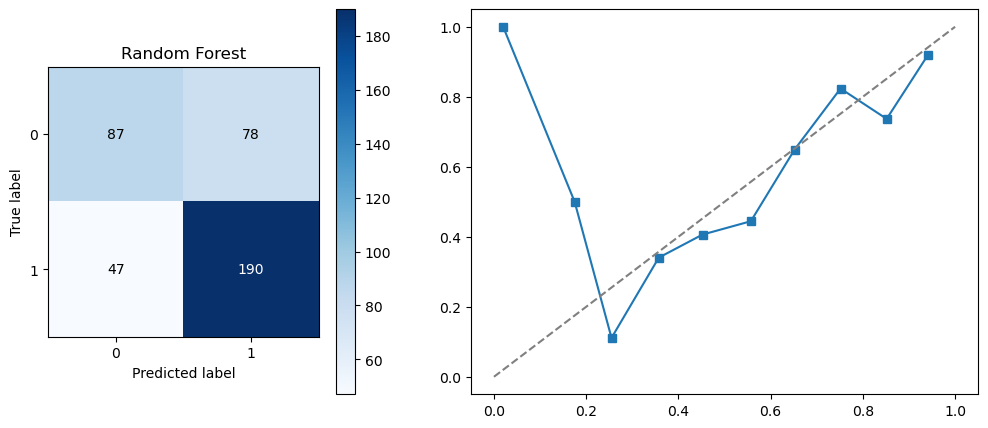

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

# Entrena y evalúa el modelo de Random Forest
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_rf = modelo_rf.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_rf.predict(X_test)

resultados = guardo_resultados('Random Forest', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'Random Forest'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_rf.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

SVM (Support Vector Machine)

C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\4213590849.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


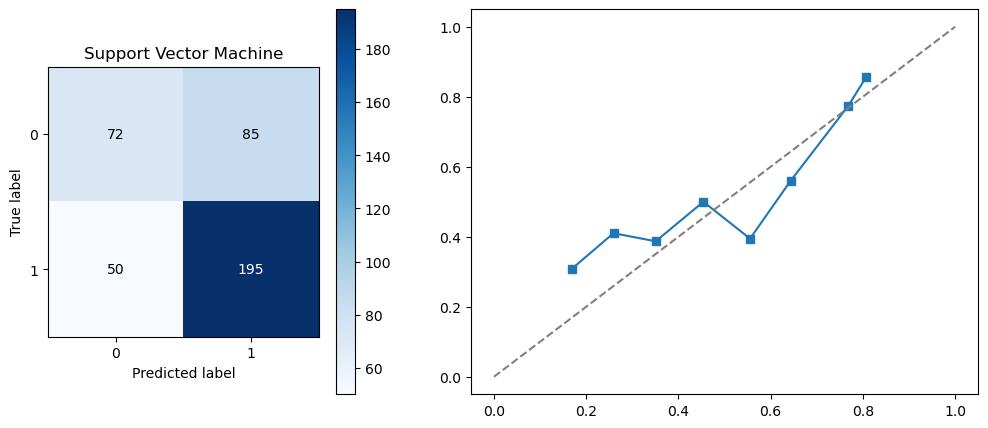

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

# Entrena y evalúa el modelo de Support Vector Machine (SVM)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_svc = modelo_svc.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_svc.predict(X_test)

resultados = guardo_resultados('Support Vector Machine', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'Support Vector Machine'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_svc.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

AdaBoost

C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\33140943.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


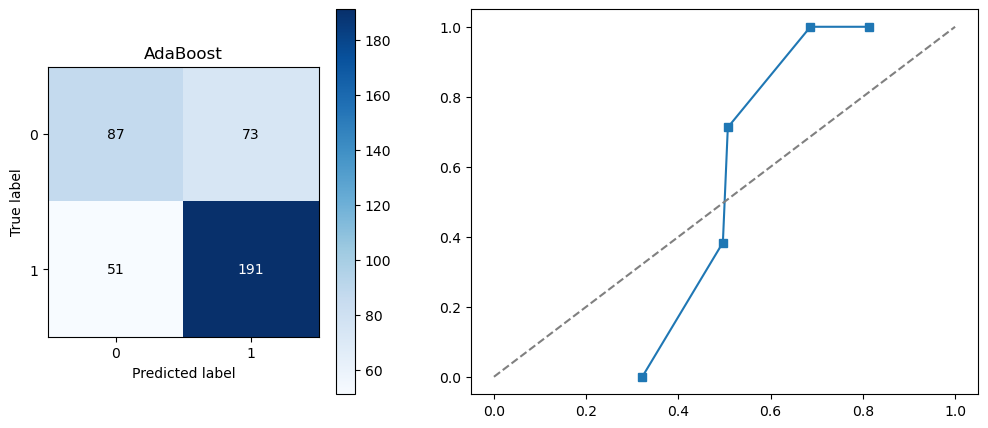

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

# Entrena y evalúa el modelo AdaBoost
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_adaboost = modelo_adaboost.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_adaboost.predict(X_test)

resultados = guardo_resultados('AdaBoost', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'AdaBoost'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_adaboost.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

XGBoost

C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\1188965047.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


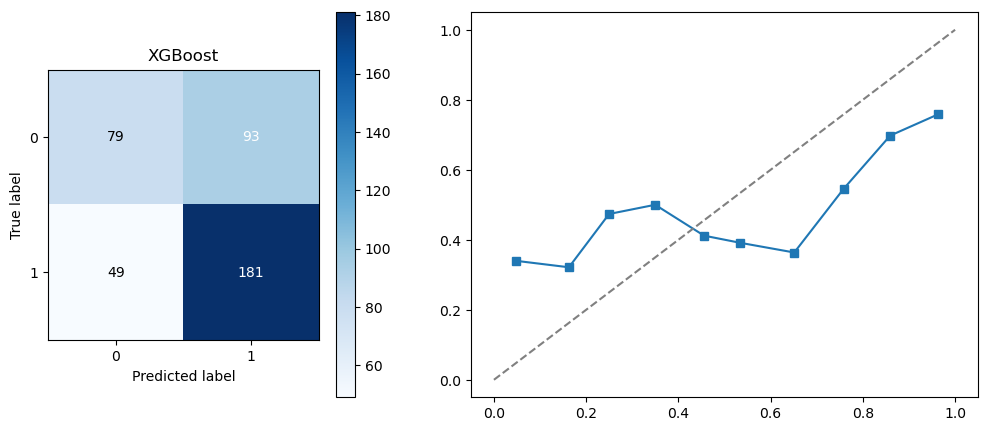

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

# Entrena y evalúa el modelo XGBoost
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_xgb = modelo_xgb.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_xgb.predict(X_test)

resultados = guardo_resultados('XGBoost', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'XGBoost'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_xgb.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

KNN (K-Nearest Neighbors)

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\1833329204.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


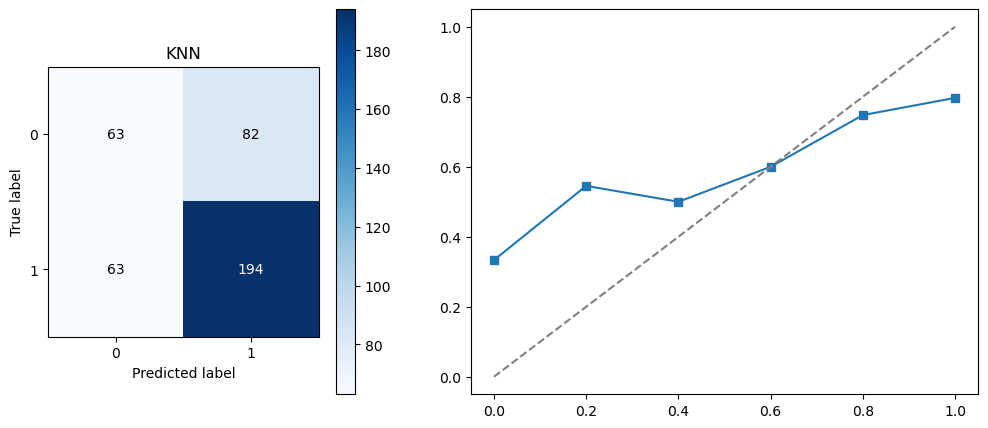

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

# Entrena y evalúa el modelo K-Nearest Neighbors (KNN)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_knn = modelo_knn.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_knn.predict(X_test)

resultados = guardo_resultados('KNN', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'KNN'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_knn.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

In [26]:
resultados_df

,Metodo,Accuracy,Precision,Recall,ROCAUC,F1-Score,FPR,FNR,Tiempo
0,Regresión Logística,0.731343,0.771218,0.819608,0.698920,0.794677,0.421769,0.180392,0.050847
1,Random Forest,0.689055,0.708955,0.801688,0.664480,0.752475,0.472727,0.198312,0.167552
2,Support Vector Machine,0.664179,0.696429,0.795918,0.627259,0.742857,0.541401,0.204082,0.161526
3,AdaBoost,0.691542,0.723485,0.789256,0.666503,0.754941,0.456250,0.210744,0.073803
4,XGBoost,0.646766,0.660584,0.786957,0.623129,0.718254,0.540698,0.213043,0.089761
5,KNN,0.639303,0.702899,0.754864,0.594673,0.727955,0.565517,0.245136,0.002994


Hay una variacion importante en las metricas de los modelos al correrlos en diferentes ocasiones, esto es producto de la cantidad de datos que tiene el dataset. De todas formas, bbservo que regresion logistica, KNN y SVM, ademas de tener buenas metricas se encuentran mas calibrados, tiene un comportamiento mas "natural" respecto a los datos.

# Ajuste hiperparametros

Regresiòn Logistica

In [27]:
modelo_logreg_tuned = LogisticRegression()

parameters = {'solver': ['liblinear','newton-cholesky'], 
              'penalty': ['l1', 'l2'], 
              'max_iter': [10, 50, 100, 200, 300],
              'multi_class' :['ovr'],
              'class_weight' :['balanced']
             }

grid = GridSearchCV(modelo_logreg_tuned, parameters, cv=5, verbose=3)

cv_results = grid.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.668 total time=   0.0s
[CV 2/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.694 total time=   0.0s
[CV 3/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.604 total time=   0.0s
[CV 4/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.694 total time=   0.0s
[CV 5/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.664 total time=   0.0s
[CV 1/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5] END class_weight=balanced, max_iter=10, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5] END class_weight=balanced

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

[CV 4/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.690 total time=   0.0s
[CV 5/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.664 total time=   0.0s
[CV 1/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/5] END class_weight=balanced, max_iter=50, multi_class=ovr, penalty=l2, solver

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError(
Val

In [28]:
cv_results.best_params_

{'class_weight': 'balanced',
 'max_iter': 50,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'solver': 'liblinear'}

In [29]:
modelo_logreg_tuned = LogisticRegression(class_weight='balanced', max_iter=50, multi_class='ovr', penalty='l1', solver='liblinear')

C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\3025007928.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


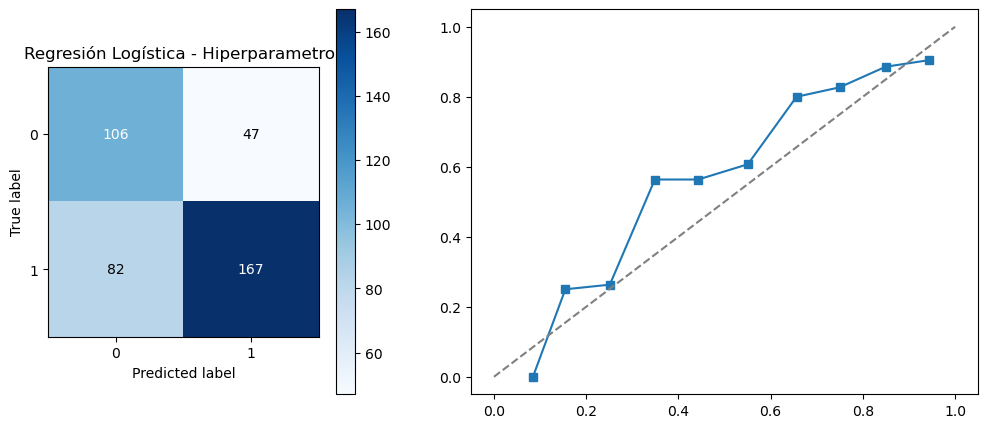

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, stratify=y)
start = time.time()
modelo_logreg_tuned = modelo_logreg_tuned.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_logreg_tuned.predict(X_test)

resultados = guardo_resultados('Regresión Logística - Hiperparametros', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'Regresión Logística - Hiperparametros'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_logreg_tuned.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

SVM (Support Vector Machine)

In [31]:
modelo_svc_tuned = SVC(probability=True)

parameters_SVM = {
              'C': [0.1, 1, 10], 
              'kernel': ['linear', 'rbf', 'poly'],
              'class_weight': [None, 'balanced'],
              'max_iter': [100, 300, 500],
              'shrinking' :[True,False],
              'decision_function_shape': ['ovo','ovr']
             }

gridsvm = GridSearchCV(modelo_svc_tuned, parameters_SVM, cv=5, verbose=3)

resultssvm = gridsvm.fit(X,y)

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.672 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.321 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.493 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.687 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.672 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.672 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.321 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.493 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.687 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.672 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.425 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.425 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.399 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.735 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.631 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.672 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.399 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.631 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.672 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.657 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.384 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.504 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.657 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.735 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.384 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.504 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.590 total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.660 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.590 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.660 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.649 total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.705 total time=   0.1s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.743 total time=   0.1s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.687 total time=   0.1s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.660 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.649 total time=   0.1s
[CV 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.604 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.675 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.604 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.743 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.668 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.604 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.672 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.638 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.701 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.694 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.597 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.672 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.638 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.701 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.694 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.597 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.631 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.713 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.720 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.668 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.642 total time=   0.

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.493 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.687 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.672 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.672 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.321 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.493 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.687 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.698 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.425 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.698 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.425 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.399 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.631 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.672 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.399 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.631 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.672 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.657 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.384 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.504 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.657 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.735 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.384 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.504 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.590 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.425 total time=   0.1s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.660 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.590 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.660 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.649 total time=   0.1s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.705 total time=   0.1s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.743 total time=   0.1s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.687 total time=   0.2s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.660 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.649 total time=   0.1s
[CV 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.675 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.604 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.743 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.668 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.604 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.672 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.638 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.701 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.694 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.597 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.672 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.638 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.701 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.694 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.597 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.631 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.713 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.720 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.668 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.642 total time=   0.

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.396 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.451 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.571 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.709 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.578 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.396 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, s

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.593 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.578 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.493 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.631 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.627 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.593 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.578 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.493 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.631 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.627 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.608 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.735 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.709 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.668 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.660 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.608 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.735 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.668 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.660 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.1s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.1s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.377 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.1s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.381 total time=   0.1s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.377 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.377 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.619 total time=   0.1s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.377 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.571 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.709 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.578 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.396 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.451 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.571 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.709 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.578 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, sh

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.593 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.578 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.493 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.631 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.627 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.593 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.578 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.493 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.631 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.627 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.608 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.735 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.668 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.660 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.608 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.668 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.660 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.377 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.1s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.381 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.377 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.377 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.377 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.377 total time=   0.1s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.646 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.720 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.623 total time= 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.425 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.642 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.410 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.425 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.642 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.410 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.638 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.560 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.660 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.567 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.664 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.638 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.560 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.660 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.567 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.657 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.735 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.384 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.504 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.657 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.384 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.504 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.590 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.638 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.660 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.649 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.590 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.638 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.660 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.649 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.694 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.660 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.694 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.660 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.567 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.578 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.597 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.660 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.567 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.578 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.597 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.660 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.668 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.612 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.597 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.612 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.668 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.612 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.597 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.612 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.646 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.724 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.713 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.675 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.634 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.724 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.675 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.634 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.646 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.720 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.425 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.642 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.410 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.425 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.705 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.642 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.410 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.638 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.560 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.660 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.567 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.664 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.638 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.560 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.660 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.567 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.657 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.735 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.384 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.504 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.657 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.384 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.504 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.590 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.638 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.660 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.649 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.590 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.638 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.660 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.649 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.694 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.660 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.694 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.660 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.567 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.578 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.597 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.660 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.567 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.578 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.597 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.660 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.668 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.612 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.597 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.612 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.668 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.612 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.597 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.612 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.724 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.675 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.634 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.646 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.724 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.713 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 4/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.675 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.634 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.571 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.504 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.571 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.664 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.504 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.433 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.392 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.310 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.433 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.451 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.272 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.631 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.668 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.582 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.451 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.272 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.631 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.668 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.582 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.705 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.377 total time=   0.1s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.381 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.705 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.381 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.377 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.631 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.433 total time=   0.1s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.675 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.571 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.631 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.433 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.675 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.571 total time=   0.1s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.687 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.687 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.571 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.664 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.504 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, sc

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.392 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.310 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.433 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.646 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.392 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.310 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.433 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.646 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.451 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.272 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.631 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.668 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.582 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.451 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.272 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.631 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.668 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.582 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.705 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.377 total time=   0.1s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.381 total time=   0.1s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.705 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.381 total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.377 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.631 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.433 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.675 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.571 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.381 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.631 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.433 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.675 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.571 total time=   0.1s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.687 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 tot

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.687 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.623 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 4/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.623 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.433 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.705 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.653 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.642 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.563 total t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.433 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.705 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.653 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.642 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.563 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.593 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.698 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=True;, score=0.511 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.593 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.698 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.396 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.522 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinking=False;, score=0.511 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.440 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.604 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.675 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.451 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.440 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.604 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.675 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.451 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.675 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.735 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.429 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.549 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.664 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.675 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.735 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.429 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.549 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.649 total time=   0.1s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.444 total time=   0.1s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.586 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.653 total time=   0.1s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.649 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.425 total time=   0.1s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.444 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.586 total time=   0.1s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.683 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.683 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.668 total time=   0.1s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.567 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.519 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.601 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.567 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.519 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.601 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.578 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.642 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.578 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.642 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.690 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.638 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.623 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.690 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.638 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.433 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.705 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.653 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.642 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.563 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=False;, score=0.433 total time=

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.593 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.698 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.396 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.522 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.511 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.593 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.698 total tim

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.522 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.511 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.440 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.604 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.675 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.451 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.440 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.604 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.675 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.451 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.664 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.675 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.735 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.429 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.549 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.675 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.735 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.429 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.549 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.649 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.425 total time=   0.1s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.444 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.586 total time=   0.1s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.649 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.444 total time=   0.1s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.586 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.653 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.683 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.716 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.743 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.683 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.668 total time=   0.1s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.567 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.519 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.601 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.567 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.519 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.601 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.608 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.578 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.619 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.642 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.578 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.619 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.642 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.619 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.690 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.638 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.623 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.619 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 4/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.690 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.638 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.571 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.336 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.627 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=True;, score=0.433 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.571 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.336 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.627 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.664 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=100, shrinking=False;, score=0.433 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=300, shrinki

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.604 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.597 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.541 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.556 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=True;, score=0.601 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.604 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.597 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.541 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.556 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=linear, max_iter=500, shrinking=False;, score=0.601 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.384 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.638 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.608 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.384 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.638 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.608 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=100, shrinking=False;, score=0.377 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.634 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.433 total time=   0.1s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.601 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=True;, score=0.608 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.634 total time=   0.1s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.433 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.601 total time=   0.1s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=300, shrinking=False;, score=0.608 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.500 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.366 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.313 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=True;, score=0.646 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.500 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.366 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.313 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=rbf, max_iter=500, shrinking=False;, score=0.646 total time=   0.1s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.593 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.478 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.590 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=True;, score=0.590 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=100, shrinking=False;, score=0.

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.519 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.586 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.563 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.511 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=True;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.519 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.586 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.563 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.511 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=300, shrinking=False;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.649 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.616 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.396 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.616 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.649 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.616 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.396 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.616 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovo, kernel=poly, max_iter=500, shrinking=False;, score=0.664 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.571 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.336 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.627 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.664 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=True;, score=0.433 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=100, shrinking=Fal

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.616 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.571 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.675 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.627 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=True;, score=0.597 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.616 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=F

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.675 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.627 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=300, shrinking=False;, score=0.597 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.604 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.597 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.541 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).

[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.556 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=True;, score=0.601 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.604 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.597 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.541 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.556 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=linear, max_iter=500, shrinking=False;, score=0.601 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.384 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.381 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.638 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.608 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=True;, score=0.377 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.384 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.381 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.638 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.608 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=100, shrinking=False;, score=0.377 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.634 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.433 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.601 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.668 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=True;, score=0.608 total time=   0.1s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.634 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.433 total time=   0.1s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.601 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.668 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=300, shrinking=False;, score=0.608 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.500 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.366 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.313 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=True;, score=0.646 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.500 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.366 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.313 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.425 total time=   0.1s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=rbf, max_iter=500, shrinking=False;, score=0.646 total time=   0.1s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.623 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.593 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.478 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.590 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=True;, score=0.590 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).

[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.623 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.593 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.478 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.590 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=100, shrinking=False;, score=0.590 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.519 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.586 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.563 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.511 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=True;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.519 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).

[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.586 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.563 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.511 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=300, shrinking=False;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.649 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.616 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.396 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.616 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=True;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.649 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.616 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.396 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.616 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, class_weight=balanced, decision_function_shape=ovr, kernel=poly, max_iter=500, shrinking=False;, score=0.664 total time=   0.0s


C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [32]:
resultssvm.best_params_

{'C': 10,
 'class_weight': None,
 'decision_function_shape': 'ovo',
 'kernel': 'rbf',
 'max_iter': 500,
 'shrinking': True}

In [33]:
modelo_svc_tuned = SVC(probability=True, C=10, class_weight=None, decision_function_shape='ovo', kernel='rbf', max_iter=500, shrinking=True)

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\2970589957.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


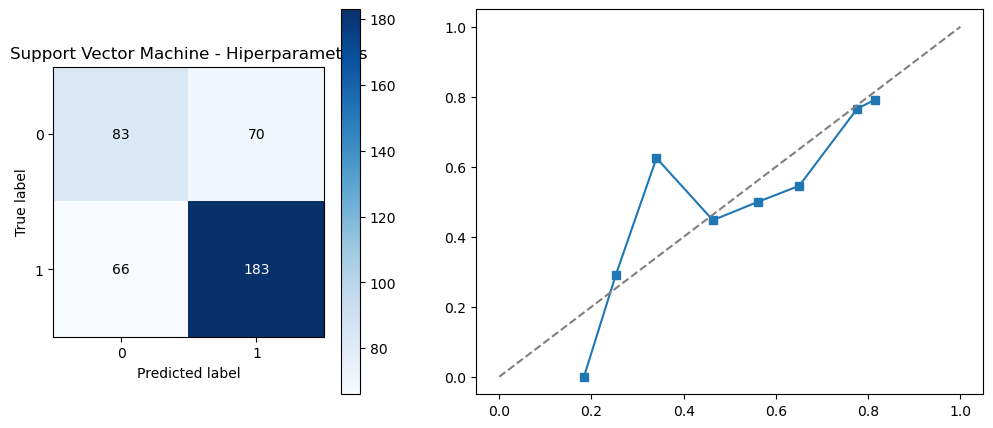

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, stratify=y)
start = time.time()
modelo_svc_tuned = modelo_svc_tuned.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_svc_tuned.predict(X_test)

resultados = guardo_resultados('Support Vector Machine - Hiperparametros', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'Support Vector Machine - Hiperparametros'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_svc_tuned.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

KNN

In [35]:
modelo_knn_tuned = KNeighborsClassifier()

parameters_knn = {
    'n_neighbors': [None, 2, 3, 4, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree'],
    'leaf_size': [5, 10, 20, 30, 40, 50, 100],
    'p': [1, 2]
}

gridknn = GridSearchCV(modelo_knn_tuned, parameters_knn, cv=5, verbose=3)

resultsknn = gridknn.fit(X,y)

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_siz

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=1, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=1, weights=distance;, score=0.601 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.590 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.571 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.567 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.537 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.578 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=2, p=2, weights=distance;, score=0.586 total time=   0.

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance;, score=0.627 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.619 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.604 total time=   0.

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=2, weights=uniform;, score=0.604 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=2, weights=uniform;, score=0.608 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=2, weights=uniform;, score=0.593 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=4, p=2, weights=uniform;, score=0.619 total time=   0

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=1, weights=uniform;, score=0.657 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=1, weights=distance;, score=0.668 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=2, weights=uniform;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=5, p=2, weights=uniform;, score=0.634 total time=   0

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=1, weights=distance;, score=0.690 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=1, weights=distance;, score=0.683 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=1, weights=distance;, score=0.668 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=7, p=2, weights=uniform;, score=0.646 total time=   0

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=1, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=1, weights=distance;, score=0.657 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=5, n_neighbors=10, p=2, weights=uniform;, score=0.649 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=None, p=2, weights=distance;, score=n

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=2, p=2, weights=distance;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.638 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.631 total t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=uniform;, score=0.608 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=uniform;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=uniform;, score=0.616 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=uniform;, score=0.642 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=4, p=1, weights=distance;, score=0.664 total t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=uniform;, score=0.687 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=uniform;, score=0.687 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.687 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.683 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.649 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=uniform;, score=0.660 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=distance;, score=0.657 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.6

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=2, p=1, weights=uniform;, score=0.575 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=2, p=1, weights=uniform;, score=0.563

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=uniform;, score=0.612 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=uniform;, score=0.623 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=uniform;, score=0.616 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=uniform;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=4, p=1, weights=distance;, score=0.664 total t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform;, score=0.653 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=uniform;, score=0.657 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform;, score=0.642 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=distance;, score=0.657 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=20, n_neighbors=10, p=2, weights=uniform;, score=0.6

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=2, p=1, weights=uniform;, score=0.575 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=2, p=1, weights=uniform;, score=0.563 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=2, p=1, weights=uniform;, score=0.571 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=2, p=1, weights=uniform;, score=0.552 t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.634 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=uniform;, score=0.623 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=uniform;, score=0.616 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=uniform;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=4, p=2, weights=uniform;, score=0.604 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=uniform;, score=0.653 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=2, weights=uniform;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=5, p=2, weights=uniform;, score=0.631 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=uniform;, score=0.690 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.660 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.69

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=1, weights=distance;, score=0.627 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.623 total t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=uniform;, score=0.616 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=uniform;, score=0.590 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.601 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.668 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.649 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=uniform;, score=0.683 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.6

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=None, p=2, weights=uniform;, score=n

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=3, p=2, weights=distance;, score=0.612 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.612 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.616 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.638 total t

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.653 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=distance;, score=0.668 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=5, p=1, weights=distance;, score=0.646 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.687 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.657 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.683 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=7, p=2, weights=uniform;, score=0.653 total 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.690 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=50, n_neighbors=10, p=2, weights=distance;, score=0.66

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=uniform;, score=0.571 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=uniform;, score=0.552 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=uniform;, score=0.597 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.608 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.604 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.601 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=2, p=2, weights=uniform;, score=0.5

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=1, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.627 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.619 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.604 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=3, p=2, weights=distance;, score=0.62

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.608 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.593 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.590 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.601 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.6

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=5, p=2, weights=distance;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=5, p=2, weights=distance;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=5, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=5, p=2, weights=distance;, score=0.634 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=5, p=2, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=7, p=1, weights=uniform;, score=0.683 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=7, p=1, weights=uniform;, score=0.657 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=7, p=1, weights=uniform;, score=0.687 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=7, p=1, weights=uniform;, score=0.6

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.683 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.657 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.642 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=100, n_neighbors=10, p=1, weights=distance;, s

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=distance;, score=nan total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=None, p=1, weights=

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.571 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.567 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.537 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=uniform;, score=0.578 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=distance;, score=0.586 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=distance;, score=0.575 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=distance;, score=0.597 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=distance;, score=0.597 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=2, p=2, weights=distance;, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.619 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=uniform;, score=0.604 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=4, p=1, weights=uniform;, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=uniform;, score=0.634 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=distance;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=distance;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=distance;, score=0.634 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=2, weights=distance;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=7, p=1, weights=uniform;, score=0.683 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=7, p=1, weights=uniform;, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=uniform;, score=0.690 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=distance;, score=0.660 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=distance;, score=0.698 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=5, n_neighbors=10, p=2, weights=distance;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=None, p=1, weight

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=0.575 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=0.549 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=0.593 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=distance;, score=0.608 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=distance;, score=0.604 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=distance;, score=0.601 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=2, p=2, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=3, p=2, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.653 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=2, weights=uniform;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=2, weights=uniform;, score=0.634 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=2, weights=dis

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.660 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=distance;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=2, weights=dis

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.690 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=distance;, score=0.660 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, we

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=uniform;, score=0.571 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=uniform;, score=0.552 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=uniform;, score=0.593 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=distance;, score=0.608 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=distance;, score=0.604 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=distance;, score=0.601 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=2, p=2, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=2, weights=uniform;, score=0.627 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=2, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=2, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=distance;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=distance;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=dis

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=10, p=2, weights=distance;, score=0.660 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=10, p=2, weights=distance;, score=0.698 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=10, p=2, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=None, p=1

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=uniform;, score=0.590 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=uniform;, score=0.567 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=uniform;, score=0.560 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=uniform;, score=0.545 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=uniform;, score=0.578 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=distance;, score=0.586 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=distance;, score=0.575 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=2, p=2, weights=dis

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=uniform;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=uniform;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=distance;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=distance;, score=0.623 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=di

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=uniform;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=distance;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=distance;, score=0.623 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=2, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=1, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.657 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.642 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.649 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.642 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=1, weights=uniform;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=1, weights=uniform;, score=0.683 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=1, weight

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.698 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=None, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=None, p=1, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=uniform;, score=0.567 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=uniform;, score=0.560 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=uniform;, score=0.541 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=uniform;, score=0.582 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=distance;, score=0.586 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=distance;, score=0.575 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=distance;, score=0.597 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=distance;, score=0.597 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=2, p=2, weights=di

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=2, weights=uniform;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.623 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=2, weights=distance;, score=0.612 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=4, p=1, weights=uniform;, score=0.612 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=4, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=4, p=1, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=4, p=2, weights=distance;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.668 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.649 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform;, score=0.653 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=1, weights=dis

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform;, score=0.687 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance;, score=0.687 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance;, score=0.657 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance;, score=0.683 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=di

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=uniform;, score=0.646 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=40, n_neighbors=10, p=2, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 726, in kneighbors
    if n_neighbors

[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=None, p=2, weights=distance;, score=nan total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=2, p=1, weights=uniform;, score=0.575 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=2, p=1, weights=uniform;, score=0.567 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=2, p=1, weights=uniform;, score=0.582 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=2, p=1, weig

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.627 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.616 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=uniform;, score=0.638 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.642 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.638 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=1, weights=distance;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=4, p=2, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.687 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.657 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.683 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=distance;, score=0.660 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=2, weights=u

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 5/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.646 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.653 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.690 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=uniform;, score=0.649 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=distance;, score=0.660 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, weights=distance;, score=0.646 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=50, n_neighbors=10, p=2, we

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=uniform;, score=0.552 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=uniform;, score=0.597 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.608 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.604 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.601 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=1, weights=distance;, score=0.634 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=2, weights=uniform;, score=0.590 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=2, p=2, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=1, weights=distance;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=1, weights=distance;, score=0.631 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.627 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.619 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.623 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=2, weights=uniform;, score=0.604 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=3, p=2, we

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.593 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.619 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=uniform;, score=0.590 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.627 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.601 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.616 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.631 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=4, p=2, weights=distance;, score=0.608 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=1, 

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.683 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.657 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.664 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=uniform;, score=0.642 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=distance;, score=0.675 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=distance;, score=0.672 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10, p=1, weights=distance;, score=0.664 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=100, n_neighbors=10

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [36]:
resultsknn.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'n_neighbors': 7,
 'p': 1,
 'weights': 'uniform'}

In [37]:
modelo_knn_tuned = KNeighborsClassifier(algorithm= 'auto', leaf_size= 5, n_neighbors= 7, p= 1, weights= 'uniform')

C:\Users\fgilb\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\fgilb\AppData\Local\Temp\ipykernel_18824\3702002850.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultados, ignore_index=True)


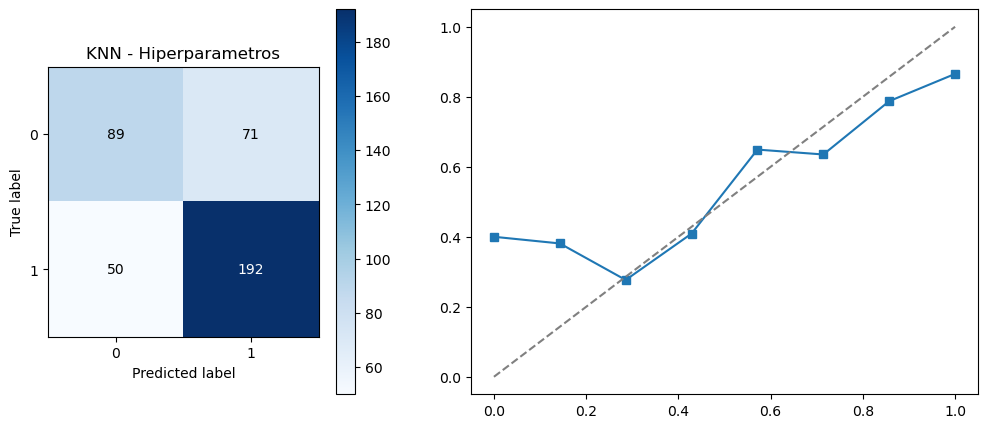

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

# Entrena y evalúa el modelo K-Nearest Neighbors (KNN)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
start = time.time()
modelo_knn = modelo_knn_tuned.fit(X_train, y_train)
end = time.time()
tiempo_ejecucion = end - start
y_pred = modelo_knn_tuned.predict(X_test)

resultados = guardo_resultados('KNN - Hiperparametros', y_test, y_pred, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)
cm = metrics.confusion_matrix(y_test, y_pred)
modelo = 'KNN - Hiperparametros'
plot_confusion_matrix(y_test, y_pred, modelo, ax=axs[0])

y_test_predict_proba = modelo_knn_tuned.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

plt.show()

In [39]:
resultados_df.sort_values(by="Accuracy", ascending=False)

,Metodo,Accuracy,Precision,Recall,ROCAUC,F1-Score,FPR,FNR,Tiempo
0,Regresión Logística,0.731343,0.771218,0.819608,0.698920,0.794677,0.421769,0.180392,0.050847
8,KNN - Hiperparametros,0.699005,0.730038,0.793388,0.674819,0.760396,0.443750,0.206612,0.003037
3,AdaBoost,0.691542,0.723485,0.789256,0.666503,0.754941,0.456250,0.210744,0.073803
1,Random Forest,0.689055,0.708955,0.801688,0.664480,0.752475,0.472727,0.198312,0.167552
6,Regresión Logística - Hiperparametros,0.679104,0.780374,0.670683,0.681747,0.721382,0.307190,0.329317,0.037898
2,Support Vector Machine,0.664179,0.696429,0.795918,0.627259,0.742857,0.541401,0.204082,0.161526
7,Support Vector Machine - Hiperparametros,0.661692,0.723320,0.734940,0.638712,0.729084,0.457516,0.265060,0.162551
4,XGBoost,0.646766,0.660584,0.786957,0.623129,0.718254,0.540698,0.213043,0.089761
5,KNN,0.639303,0.702899,0.754864,0.594673,0.727955,0.565517,0.245136,0.002994


Observo que a medida que corro el codigo en multiples ocasiones la performance de cada uno de los modelos varia considerablemente. Esto se debe principalmente al tamaño de la base de datos trabajada. De todas formas, si resulta concluyente que el modelo "Regresion Logistica" registra los mejores resultados, como asi tambien demuestra ser el mas calibrado de cara a la resoluciòn de esta necesidad. 